In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

In [5]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_many_well(*args, **kwargs)
    plt.show()

In [6]:
dim = 8
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)

In [7]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

# Vanilla IS

In [8]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
    print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
          var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

ESS is 0.0003414841551042793,           var is 2.9276863267306962e-05


# DReG, constant step size

In [9]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=3, n_steps_transition_operator=2,
                    step_size=1.0, transition_operator="Metropolis", learnt_dist_kwargs={"lr": 1e-5})

In [10]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.00013563945738604598


  0%|          | 0/1000 [00:00<?, ?it/s]

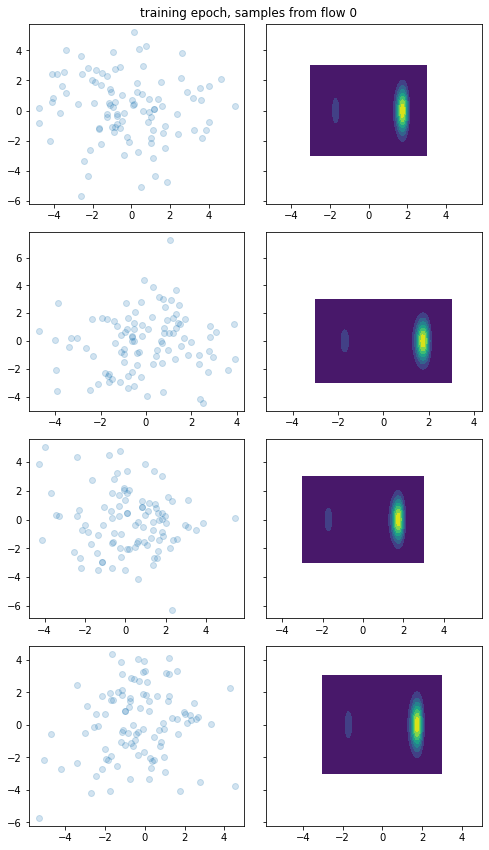

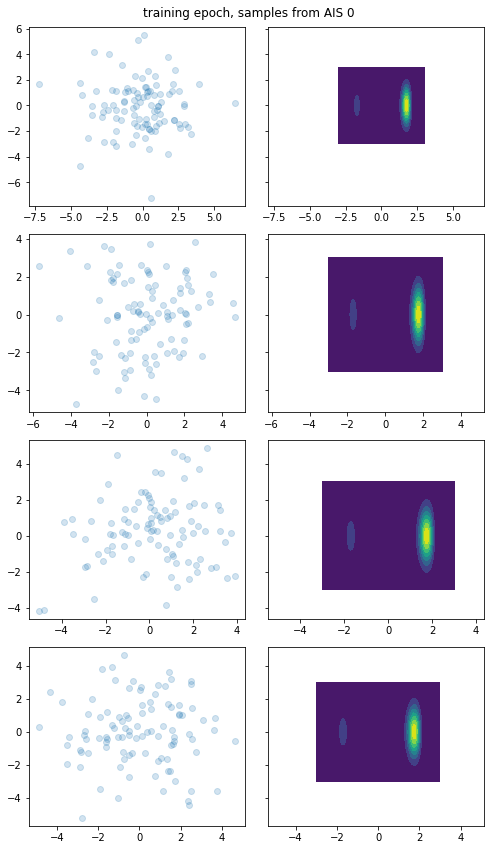

loss: 31.62150724225497,   log_p_x_post_AIS -75.16509423948935, ESS 0.017206939515890675:  20%|██        | 200/1000 [02:22<09:07,  1.46it/s] 

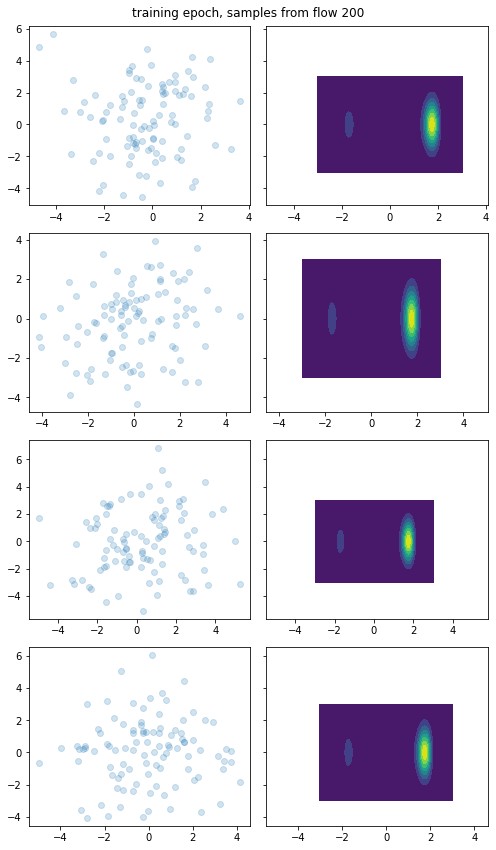

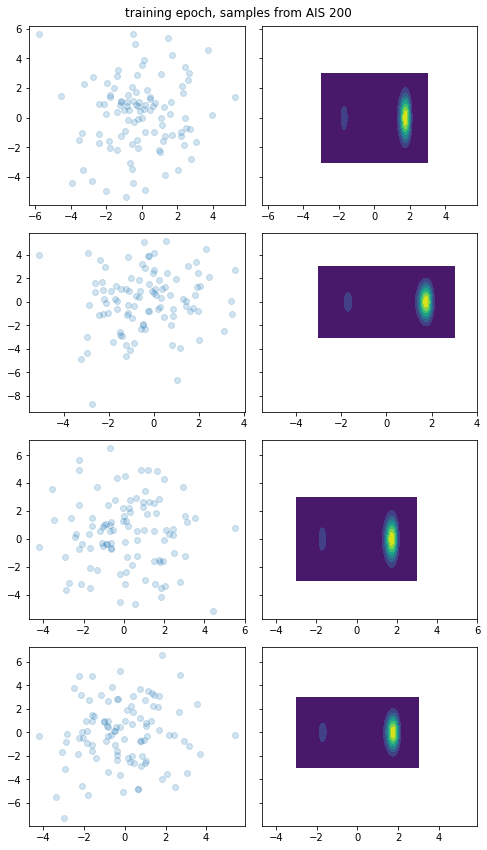

loss: 29.522984260885476,   log_p_x_post_AIS -70.84809817023948, ESS 0.01620144478315523:  40%|████      | 400/1000 [04:45<07:01,  1.42it/s] 

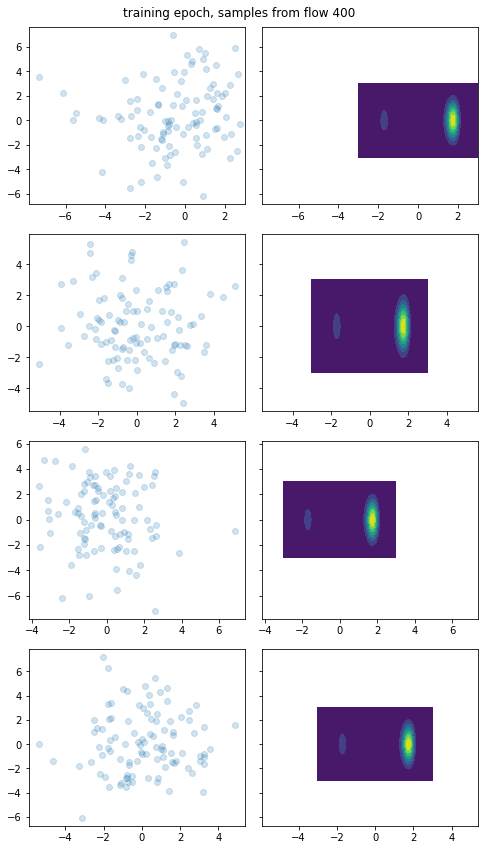

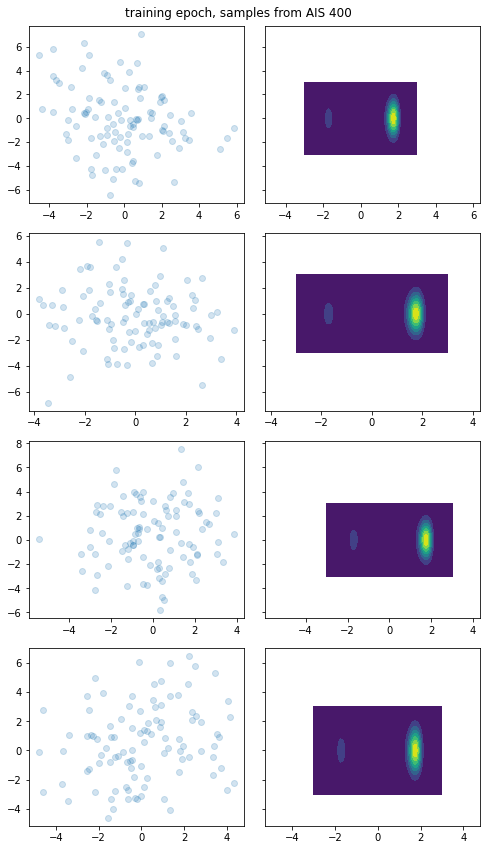

loss: 22.674362935533473,   log_p_x_post_AIS -71.45499769619401, ESS 0.01924674304251036:  60%|██████    | 600/1000 [07:11<04:49,  1.38it/s] 

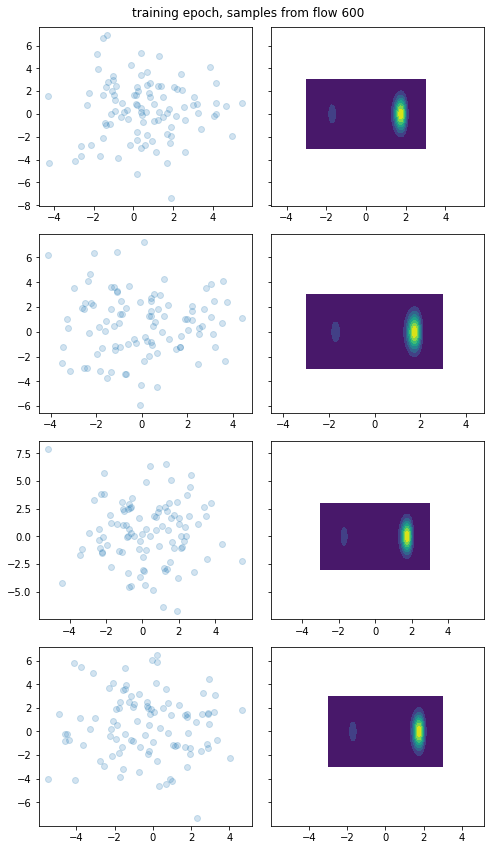

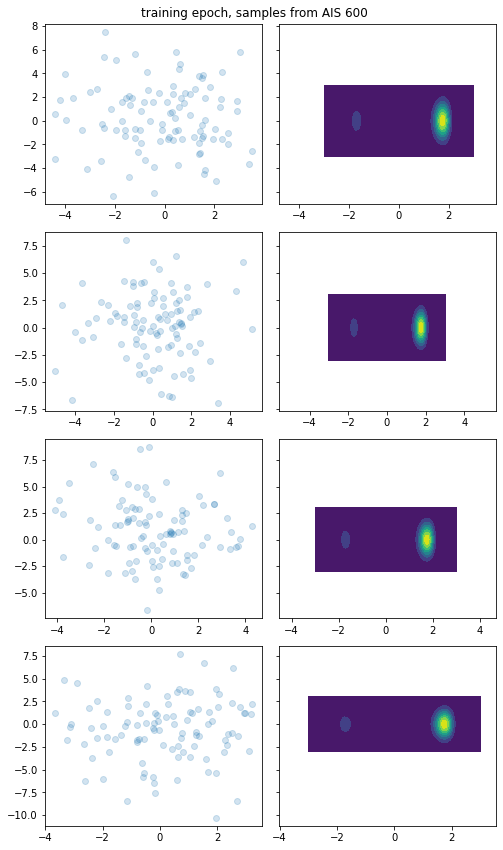

loss: 32.201550493978445,   log_p_x_post_AIS -59.616358614815965, ESS 0.014055052368096477:  80%|████████  | 800/1000 [09:34<02:18,  1.44it/s]

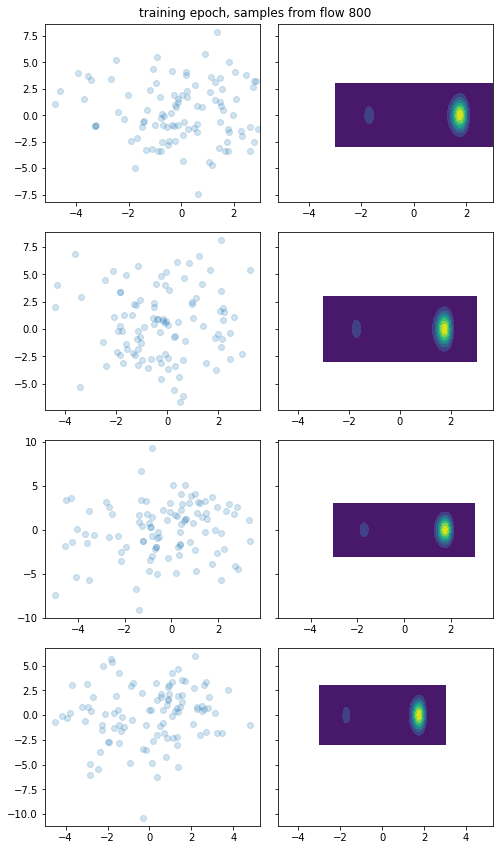

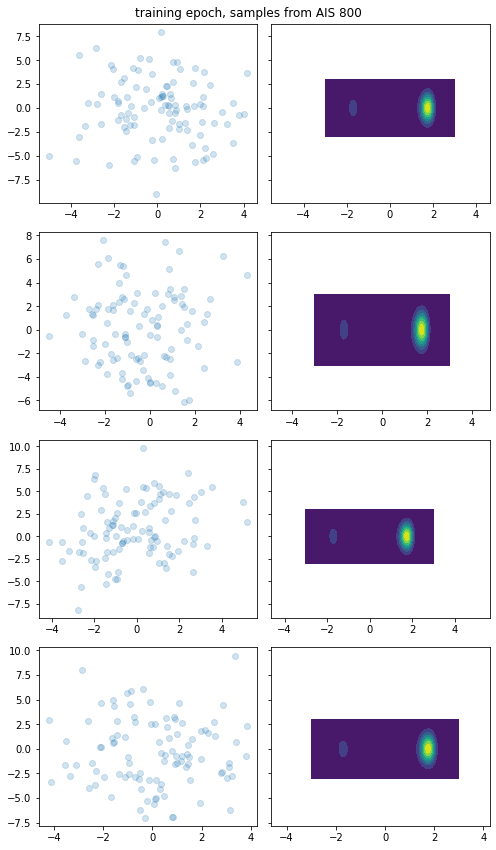

loss: 32.69557449720661,   log_p_x_post_AIS -56.16061060455387, ESS 0.013418079230812622: 100%|██████████| 1000/1000 [11:44<00:00,  1.42it/s] 


In [11]:
history = tester.train(1000, batch_size=int(1e2), intermediate_plots=True, n_plots=5, plotting_func=plotter)

In [12]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

0.00042814245073948605


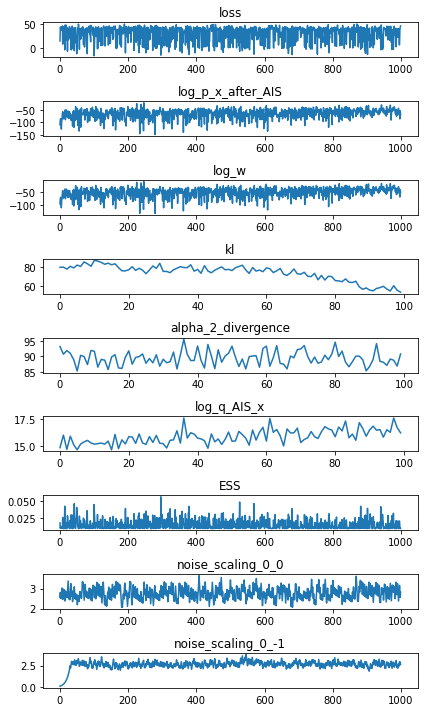

In [13]:
plot_history(history)

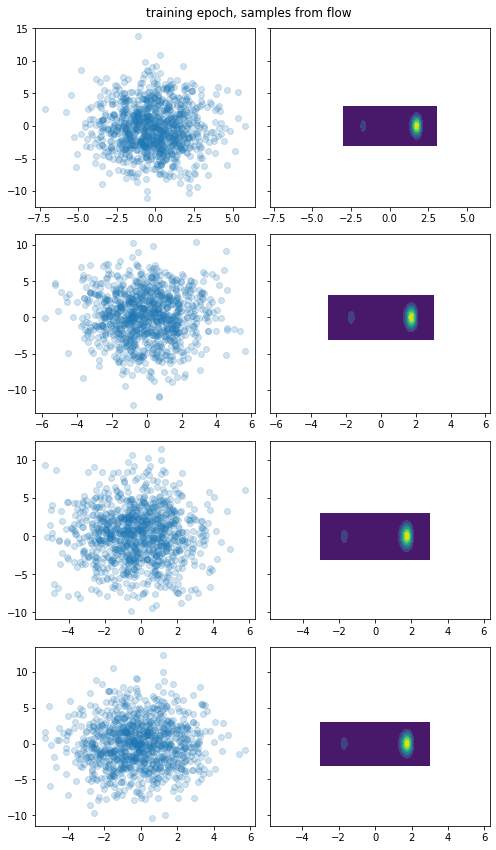

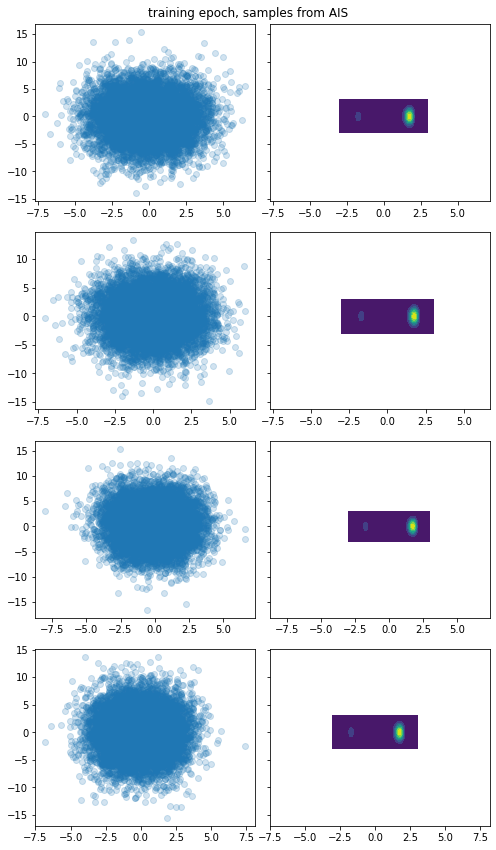

In [14]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

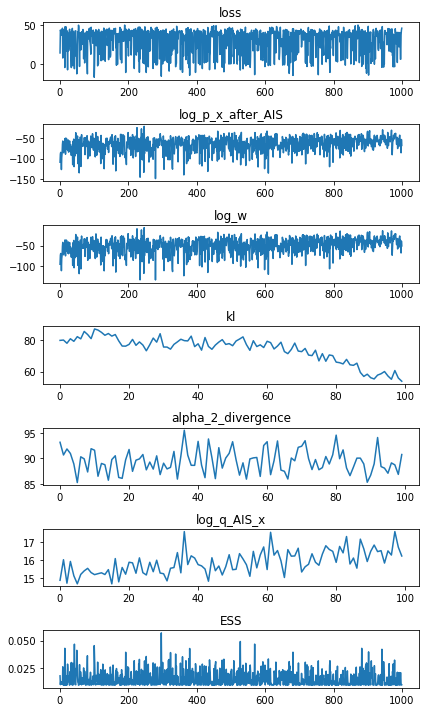

In [15]:
plot_history(dict([(key, history[key]) for key in ('loss', 'log_p_x_after_AIS', 'log_w', 'kl', 
                                               'alpha_2_divergence', 'log_q_AIS_x', 'ESS')]))

  0%|          | 0/1000 [00:00<?, ?it/s]

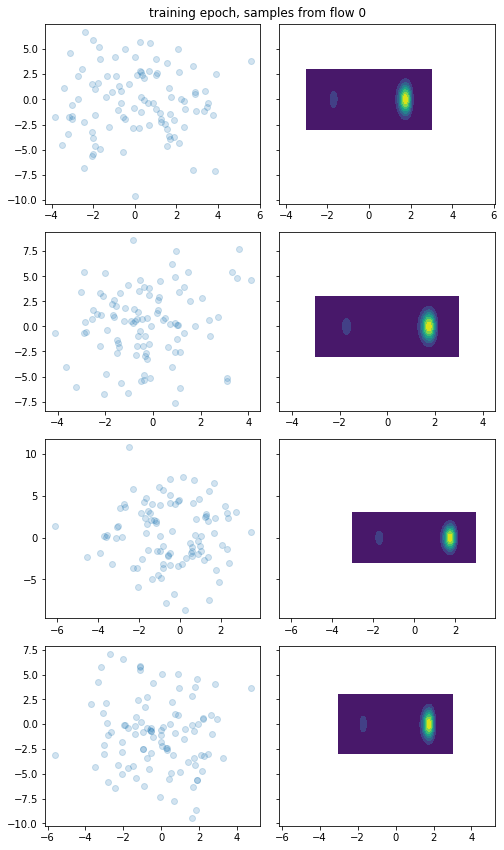

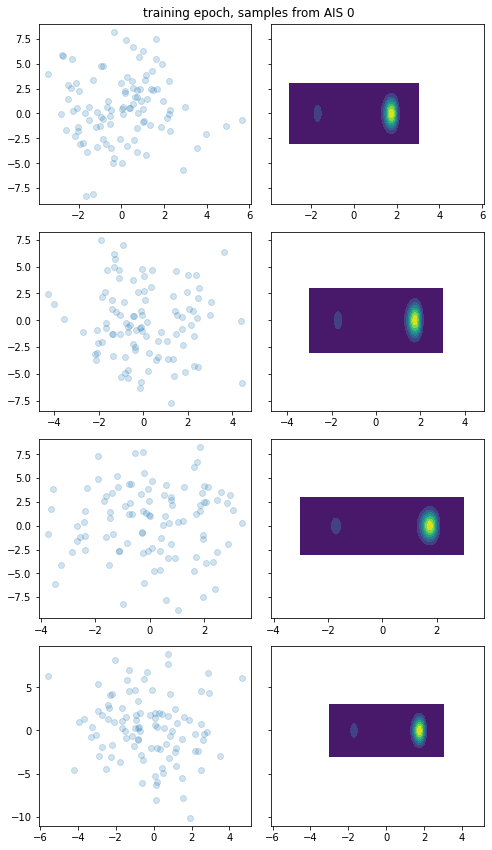

loss: 25.306447617130672,   log_p_x_post_AIS -62.10864416982248, ESS 0.017083930478946893:  20%|██        | 200/1000 [02:21<08:57,  1.49it/s] 

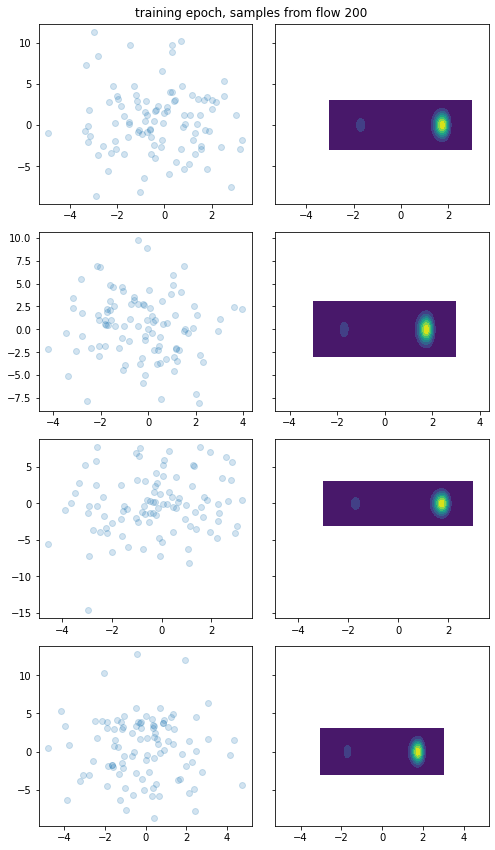

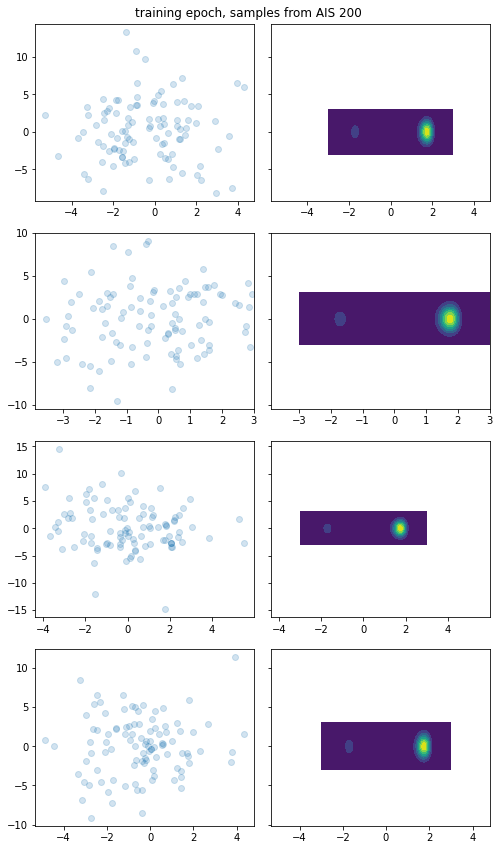

loss: 33.894548823326865,   log_p_x_post_AIS -72.10764900963548, ESS 0.012116720116164981:  40%|████      | 400/1000 [04:42<06:55,  1.44it/s] 

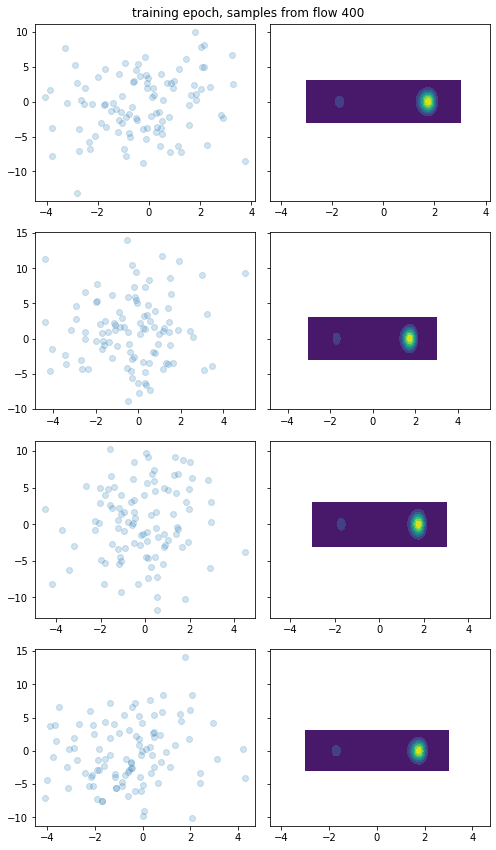

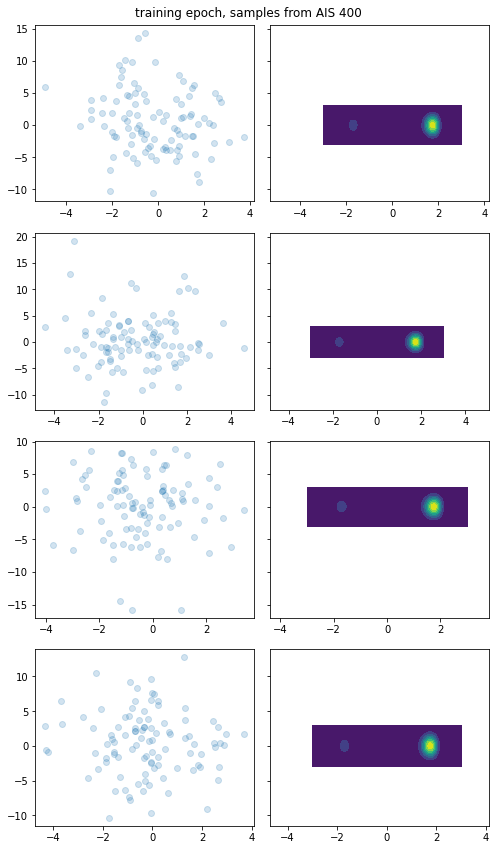

loss: 19.649281361510926,   log_p_x_post_AIS -80.53543456107496, ESS 0.01777566504803104:  55%|█████▍    | 548/1000 [06:27<05:10,  1.46it/s] 

In [ ]:
history = tester.train(1000, batch_size=int(1e2), intermediate_plots=True, n_plots=5, plotting_func=plotter)

# Normal Method

In [ ]:
from FittedModels.train import LearntDistributionManager

In [ ]:
torch.manual_seed(1)
# ******************* Parameters *******************
dim = 2
epochs = int(3e3)
n_samples_estimation = int(1e4)
batch_size = int(1e3)
lr = 5e-4
optimizer = "Adam"
loss_type = "DReG"  # "kl"  #
initial_flow_scaling = 2.0
n_flow_steps = 30
annealing = True
flow_type = "RealNVP"
n_plots = 10

In [ ]:
torch.manual_seed(0)  # 0
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps,
                           scaling_factor=initial_flow_scaling, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type=loss_type,
                                   lr=lr, optimizer=optimizer, annealing=annealing)

In [ ]:
history = tester.train(epochs, batch_size=batch_size, clip_grad_norm=True, max_grad_norm=1,
                       intermediate_plots=True, plotting_func=plotter, n_plots=n_plots)

In [ ]:
plot_history(history)